Searching around atlanta (lat: 33.7545, lon: -84.3898)
Discovering a session...
Searching with bbox: (-84.93064571678634, -83.84898448321367, 33.30480489704064, 34.20412650295936)
Session: 1933777 (via v3)
Probe stream 2818779 AirBeam3-PM2.5 | last 24h -> 0 points
Probe stream 2818779 AirBeam3-PM2.5 | last 168h -> 0 points
Probe stream 2818779 AirBeam3-PM2.5 | last 720h -> 846 points
Using window: 720 hours
Stream: 2818779 AirBeam3-PM2.5
Items returned: 846
Saved: out_csv.csv | rows: 846


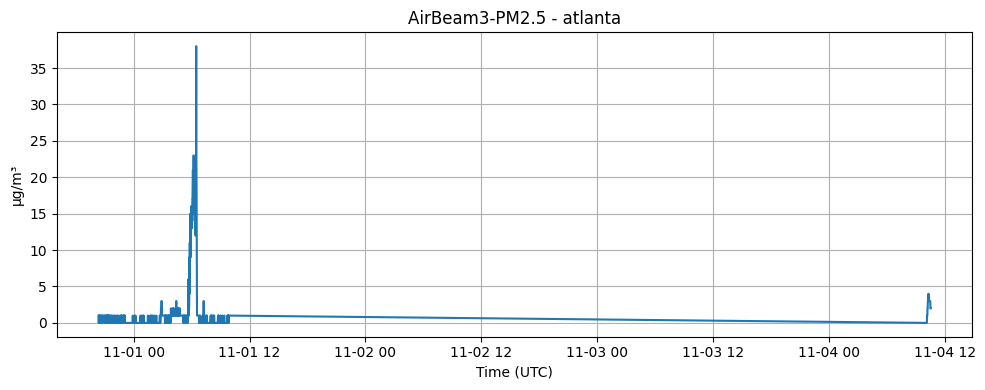

In [1]:
import sys
import math
import os
import time
import json
import urllib.parse
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


BASE = "https://aircasting.org"


#helper funcs for converting between datetime and epoch
def utc_now():
    return datetime.now(timezone.utc) #return current time in UTC timezone


def to_epoch_ms(dt: datetime) -> int:
    return int(dt.timestamp() * 1000) #converts py datetime into epoch ms (unix timestamp * 1000)


def to_epoch_s(dt: datetime) -> int:
    return int(dt.timestamp()) #same as other one but epoch s


def encode_q(obj: dict) -> str:
    return urllib.parse.quote(json.dumps(obj), safe="") #takes py dict convert to json string
#need for aircasting's mapstyle endpoints


#geocoding city --> lat,lon
def geocode_city(city: str) -> tuple[float, float] | None:
    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": city, "format": "json", "limit": 1}
    r = requests.get(url, params=params, headers={"User-Agent": "aircasting-client"}, timeout=15)
    r.raise_for_status()
    data = r.json()
    if not data:
        return None
    lat, lon = float(data[0]["lat"]), float(data[0]["lon"])
    return lat, lon


def calculate_bounding_box(lat: float, lon: float, radius_km: float = 50) -> tuple:
    #calculate bounding box around coordinates
    #earth radius in km
    R = 6371
    # convert latitude and longitude to rads
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    
    #calculate deltas
    delta_lat = radius_km / R
    delta_lon = radius_km / (R * math.cos(lat_rad))
    
    # Convert back to degrees
    north = math.degrees(lat_rad + delta_lat)
    south = math.degrees(lat_rad - delta_lat)
    east = math.degrees(lon_rad + delta_lon)
    west = math.degrees(lon_rad - delta_lon)
    
    return west, east, south, north


# session discovery
def list_sessions_v3(start_iso: str = None, end_iso: str = None, bbox: tuple = None) -> list:
    #list sessions via /api/v3/sessions, optional filters start_datetime and end_datetime
    params = {}
    if start_iso and end_iso:
        params["start_datetime"] = start_iso
        params["end_datetime"] = end_iso
    if bbox:
        params["west"] = bbox[0]
        params["east"] = bbox[1]
        params["south"] = bbox[2]
        params["north"] = bbox[3]
    
    print(f"Searching with bbox: {bbox}")
    r = requests.get(f"{BASE}/api/v3/sessions", params=params, timeout=30)
    r.raise_for_status()
    return r.json().get("sessions", []) #return list of sessions


def pick_fixed_session_v3(bbox: tuple = None) -> dict | None:
    #try default window (last 30 days)
    sessions = list_sessions_v3(bbox=bbox)
    fixed = next((s for s in sessions if s.get("type") == "FixedSession"), None)
    if fixed:
        return fixed
    if sessions:
        return sessions[0]

    #nothing comes back, try looser range (last 365 days)
    end = utc_now()
    start = end - timedelta(days=365)
    sessions = list_sessions_v3(
        start_iso=start.strftime("%Y-%m-%dT%H:%M:%SZ"),
        end_iso=end.strftime("%Y-%m-%dT%H:%M:%SZ"),
        bbox=bbox
    )
    fixed = next((s for s in sessions if s.get("type") == "FixedSession"), None)
    if fixed:
        return fixed
    return sessions[0] if sessions else None


def pick_fixed_session_mapstyle(bbox: tuple = None) -> dict | None:
    #try mapstyle endpoints if /v3/sessions didnt work
    #try diff sensor names or time windows or session kinds stored in vars
    sensor_names = ["AirBeam3-PM2.5", "AirBeam2-PM2.5", "AirBeam-PM2.5"]
    day_windows = [7, 30, 90]  # days
    kinds = ["active", "dormant"]

    for kind in kinds:
        for days in day_windows:
            for sensor in sensor_names:
                now = utc_now()
                q = {
                    "time_from": to_epoch_s(now - timedelta(days=days)),
                    "time_to": to_epoch_s(now),
                    "tags": "",
                    "usernames": "",
                    "west": bbox[0] if bbox else -125.00001,
                    "east": bbox[1] if bbox else -66.93457,
                    "south": bbox[2] if bbox else 24.396308,
                    "north": bbox[3] if bbox else 49.3457868,
                    "sensor_name": sensor,
                    "measurement_type": "Particulate Matter",
                    "unit_symbol": "µg/m³",
                }
                url = f"{BASE}/api/fixed/{kind}/sessions.json?q={encode_q(q)}"
                r = requests.get(url, timeout=30)
                r.raise_for_status()
                sessions = r.json().get("sessions", [])
                if sessions:
                    # Normalize to dict with id
                    s0 = sessions[0]
                    sid = (
                        s0["id"]
                        if isinstance(s0, dict) and "id" in s0
                        else (s0.get("session_id") if isinstance(s0, dict) else s0)
                    )
                    return {
                        "id": sid,
                        "picked_via": f"mapstyle:{kind}:{days}d:{sensor}",
                    }
    return None



#streams and measurements

def get_streams(session_id: int) -> list:
    #retrieve streams (types of data recorded) for a session like PM2.5 or temp or humidity and stuff
    r = requests.get(
        f"{BASE}/api/fixed/sessions/{session_id}/streams.json",
        params={"measurements_limit": 1},
        timeout=30,
    )
    r.raise_for_status()
    return r.json().get("streams", [])



def find_stream_with_data(
    #loop thru streams, try diff lookback windows until find one w data
    #return stream_id, metadata, measurements
    streams: list, lookbacks_h: list
) -> tuple[int | None, dict | None, list]:
    for s in streams:
        sid = s.get("stream_id")
        for h in lookbacks_h:
            ms, url = get_fixed_measurements(sid, h, return_url=True)
            print(
                f"Probe stream {sid} {s.get('sensor_name','')} | last {h}h -> {len(ms)} points"
            )
            if ms:
                print("Using window:", h, "hours")
                return sid, s, ms
    return None, None, []



def get_fixed_measurements(stream_id: int, hours: int = 24, return_url: bool = False):
    #fetch the actual measurements for given stream
    end_ms = int(time.time() * 1000)
    start_ms = end_ms - hours * 3600 * 1000
    r = requests.get(
        f"{BASE}/api/v3/fixed_measurements",
        params={"stream_id": stream_id, "start_time": start_ms, "end_time": end_ms},
        timeout=60,
    )
    r.raise_for_status()
    return (r.json(), r.url) if return_url else r.json()



#schema normalization funcs  so we can use pandas later
def to_datetime_any(x):
    if pd.isna(x):
        return pd.NaT
    if isinstance(x, (int, float)):
        x = int(x)
        # 10 digits -> seconds, 13 digits -> ms (heuristic)
        return pd.to_datetime(x, unit="ms" if x > 10_000_000_000 else "s", utc=True)
    # Try ISO strings
    return pd.to_datetime(x, utc=True, errors="coerce")


def coerce_df(measurements: list) -> pd.DataFrame:
    #map common alternate keys to time/value, but keep all columns
    if not measurements:
        return pd.DataFrame()

    time_keys = ["time", "measured_at", "timestamp", "recorded_at", "created_at"]
    value_keys = [
        "value",
        "value_calibrated",
        "value_ugm3",
        "value_rounded",
        "measurement_value",
    ]

    rows = []
    for m in measurements:
        t = next((m[k] for k in time_keys if k in m), None)
        v = next((m[k] for k in value_keys if k in m), None)
        row = {"time": t, "value": v}
        row.update(m)
        rows.append(row)

    df = pd.DataFrame(rows)
    if "time" in df.columns:
        df["time"] = df["time"].apply(to_datetime_any)
    return df




def main():
    #get city name from user
    #saving these vars as global to use them later
    global city_name
    city_name = input("Enter a city name (e.g., 'New York', 'Los Angeles', 'Chicago'): ").strip()
    if not city_name:
        print("No city name entered. Using default search area.")
        bbox = None
    else:
        #get coordinates for the city
        coords = geocode_city(city_name)
        if coords is None:
            print(f"Could not find coordinates for {city_name}. Using default search area.")
            bbox = None
        else:
            global lat, lon
            lat, lon = coords
            # calc bounding box around the city (50km radius) default
            bbox = calculate_bounding_box(lat, lon, radius_km=50)
            print(f"Searching around {city_name} (lat: {lat:.4f}, lon: {lon:.4f})")
    
    print("Discovering a session...")
    session = pick_fixed_session_v3(bbox=bbox)
    picked_via = "v3"
    if not session:
        session = pick_fixed_session_mapstyle(bbox=bbox)
        picked_via = session.get("picked_via", "mapstyle") if session else None

    if not session: #nothing found
        print(
            f"No sessions found near {city_name if city_name else 'the default area'}." 
        )
        sys.exit(1)

    session_id = session["id"]
    print(f"Session: {session_id} (via {picked_via})")

    streams = get_streams(session_id)
    if not streams:
        print("No streams found for this session.")
        sys.exit(1)

    #prefer PM2.5 streams first in the order
    streams_sorted = sorted(
        streams,
        key=lambda s: (
            0 if "PM2.5" in (s.get("sensor_name") or "") else 1,
            s.get("sensor_name", ""),
        ),
    )

    LOOKBACKS_H = [24, 7 * 24, 30 * 24, 90 * 24, 180 * 24, 365 * 24]
    stream_id, stream_meta, measurements = find_stream_with_data(
        streams_sorted, LOOKBACKS_H
    )

    if not measurements:
        print(
            "No streams with data in the last year for this session."
        )
        sys.exit(1)

    print("Stream:", stream_id, stream_meta.get("sensor_name"))
    print("Items returned:", len(measurements))

    #normalize and save
    df = coerce_df(measurements).dropna(subset=["time"])
    df = df.sort_values("time")
    out_csv = "out_csv.csv"
    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv, "| rows:", len(df))


    if not df.empty and "value" in df.columns:
        fig, ax = plt.subplots(figsize=(10, 4))
        sns.lineplot(data=df, x="time", y="value", ax=ax)
        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel(stream_meta.get("sensor_unit", "Value"))
        ax.set_title(f"{stream_meta.get('sensor_name', 'Stream')} - {city_name if city_name else 'Unknown Location'}")
        ax.grid(True)
        fig.tight_layout()
        plt.show()
    else:
        print("No plottable time/value columns. Check columns:", list(df.columns))

main()

In [ ]:
import arcgis
from arcgis.gis import GIS
from arcgis.apps.dashboard import Dashboard
from arcgis.apps.dashboard import SerialChart
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd
from datetime import datetime
import json

inp = "out_csv.csv"
cl_id ="pNRJQAMxohpkiwBQ"
secret = "bc0cda3fd61f4a90a823e2c568084652" #client secret didnt work

gis = GIS(
    "https://gsu.maps.arcgis.com/", 
    client_id = "pNRJQAMxohpkiwBQ",
    redirect_url = "urn:ietf:wg:oauth:2.0:oob",
    browser = True,
)


existing = gis.content.search(f'title:"Aircasting Data over Time" AND type:CSV', max_items=1)
if existing:
    #cSV exists, update the data
    csv_item = existing[0]
    csv_item.update(data=inp)
    print(f"Updated existing CSV: {csv_item.title}")
else:
    #does not exist, create new one
    csv_item = gis.content.add(
        {
            "title": f"Aircasting Data over Time",
            "type": "CSV"
        },
        data = inp
    )
    print(f"Created new CSV: {csv_item.title}")
table_item = csv_item.publish()



#----------------------------------------------------------------
#messing around with this, havent been able to get it to work yet
def create_dashboard_from_hosted_table():
    
    table_title = f"Aircasting Data over Time"
    table_search = gis.content.search(
        f'title:"{table_title}" AND type:"Feature Service"', 
        max_items=1
    )
    
    if not table_search:
        print(f"Table not found")
        return
    
    table_item = table_search[0]
    
    #get the feature layer from the table
    # hosted tables are usually the first layer in the feature service???
    table_layer = table_item.layers[0]
    
    # create or update dashboard
    dashboard_title = f"Air Quality Dashboard"
    dashboard_search = gis.content.search(
        f'title:"{dashboard_title}" AND type:Dashboard', 
        max_items=1
    )
    
    if dashboard_search:
        dashboard_item = dashboard_search[0]
        print(f"Using existing dashboard: {dashboard_item.title}")
    else:
        dashboard_item = gis.content.add({
            "type": "Dashboard",
            "title": dashboard_title,
            "tags": "air quality, monitoring, dashboard",
            "snippet": f"Air quality monitoring dashboard"
        })
        print(f"Created new dashboard: {dashboard_item.title}")
    
    
    dashboard = Dashboard(dashboard_item)
    chart = SerialChart(
        title="Air Quality Over Time",
        data_source= table_layer,  #use the table layer as data source
        category_field="time",
        series=[{
            "field": "value",  
            "name": "PM2.5"
        }],
        chart_type="line",
    )
    
    # add chart to dashboard and save
    dashboard.add_element(chart)
    dashboard.save()
    
    print(f"Dashboard created successfully!")
    print(f"Dashboard URL: {dashboard_item.homepage}")
    
    return dashboard

#i cant get any of the dashboard stuff to work right :(
create_dashboard_from_hosted_table()


Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://gsu.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=pNRJQAMxohpkiwBQ&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=f09DXbNRAKYs2KRUMJ7VFNyp7gDk4y&allow_verification=false
Updated existing CSV: Aircasting Data over Time: atlanta


IndexError: list index out of range